In [1]:
!pip install pyyaml h5py
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.applications import EfficientNetV2M,EfficientNetV2B1, ResNet152V2, DenseNet201, ConvNeXtXLarge, InceptionResNetV2, MobileNet
from keras.utils import load_img
from keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
import numpy as np
import pathlib
import shutil

import matplotlib.pyplot as plt
%matplotlib inline

#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#policy = tf.keras.mixed_precision.Policy("mixed_float16")
#tf.keras.mixed_precision.set_global_policy(policy)

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
print(os.getcwd())
#os.chdir('dataset_ovos')
path = "/content/drive/MyDrive/Pessoal/Especialização/Dados_CESAR/05_RNA e Deep Learning/dataset"
isExist = os.path.exists(path)

if not isExist:
   #os.makedirs(path)
   os.chdir('/content/drive/MyDrive/Pessoal/Especialização/Dados_CESAR/05_RNA e Deep Learning/dataset')
   !curl -L "https://app.roboflow.com/ds/t8UiiZL7No?key=L9ew2mZJt8" >> roboflow.zip ; unzip roboflow.zip; rm roboflow.zip
else:
  os.chdir('/content/drive/MyDrive/Pessoal/Especialização/Dados_CESAR/05_RNA e Deep Learning/dataset')

print(os.getcwd())
os.chdir('../')
data_dir = 'dataset/train'
data_dir = pathlib.Path(data_dir)

/content
/content/drive/MyDrive/Pessoal/Especialização/Dados_CESAR/05_RNA e Deep Learning/dataset


In [4]:

diretorio = 'dataset/valid'
count = 0
count = 0
for root_dir, cur_dir, files in os.walk(diretorio):
    count += len(files)

if count > 30:
  print('Dataset de validação já expandido')
else:
  for subdir in ['M', 'G', 'GG', 'JB']:
    subdir_path = os.path.join(diretorio, subdir)
    # List all image files in the current subdirectory
    image_paths = [os.path.join(subdir_path, filename) for filename in os.listdir(subdir_path) if filename.endswith((".jpg", ".jpeg", ".png"))]
    for image_path in image_paths:
        try:
            print('Processing: ', image_path)
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            # criar um gerador (generator) com as imagens do data augmentation
            imgAug = ImageDataGenerator(rotation_range=45, width_shift_range=0.2,
                                        height_shift_range=0.1, zoom_range=0.25,
                                        brightness_range=(0.1, 0.5), shear_range=0.25,
                                        fill_mode='nearest', horizontal_flip=True)

            imgGen = imgAug.flow(image, save_to_dir=subdir_path,
                                save_format='jpg', save_prefix='i_')

            # gerar 5 imagens por data augmentation
            counter = 0

            for (i, newImage) in enumerate(imgGen):
                #print('Generating the image number: ', counter, '/',25)
                counter += 1
                # ao gerar 5 imagens, parar o loop
                if counter == 5:
                    break
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")


diretorio = 'dataset/train'
count = 0
for root_dir, cur_dir, files in os.walk(diretorio):
    count += len(files)

if count > 30:
  print('Dataset de treinamento já expandido')
else:
  for subdir in ['M', 'G', 'GG', 'JB']:
    subdir_path = os.path.join(diretorio, subdir)

    # List all image files in the current subdirectory
    image_paths = [os.path.join(subdir_path, filename) for filename in os.listdir(subdir_path) if filename.endswith((".jpg", ".jpeg", ".png"))]
    for image_path in image_paths:
        try:
            print('Processing: ', image_path)
            image = load_img(image_path)
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            # criar um gerador (generator) com as imagens do data augmentation
            imgAug = ImageDataGenerator(rotation_range=45, width_shift_range=0.2,
                                        height_shift_range=0.1, zoom_range=0.25,
                                        brightness_range=(0.1, 0.5), shear_range=0.25,
                                        fill_mode='nearest', horizontal_flip=True)

            imgGen = imgAug.flow(image, save_to_dir=subdir_path,
                                save_format='jpg', save_prefix='i_')

            # gerar 5 imagens por data augmentation
            counter = 0

            for (i, newImage) in enumerate(imgGen):
                #print('Generating the image number: ', counter, '/',25)
                counter += 1
                # ao gerar 5 imagens, parar o loop
                if counter == 5:
                    break
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

Dataset de validação já expandido
Dataset de treinamento já expandido


In [5]:
IMG_SIZE = 224 # All images will be resized to 160x160
BATCH_SIZE = 128
input_shape = (IMG_SIZE, IMG_SIZE, 3)
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

data_dir = 'dataset/valid'
data_dir = pathlib.Path(data_dir)
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE)

Found 3203 files belonging to 4 classes.
Found 729 files belonging to 4 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['G', 'GG', 'JB', 'M']


In [7]:
#normalization_layer = layers.Rescaling(1./255)
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))

In [8]:
num_classes = len(class_names)

data_augmentation = tf.keras.Sequential([
  layers.Cropping2D(cropping=10),
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomBrightness(factor=0.2),
  layers.RandomContrast(factor=0.2),
  layers.RandomTranslation(0.2, 0.2,fill_mode='reflect', interpolation='bilinear'),

])

inputs = keras.Input(shape=input_shape)
#ds = data_augmentation(inputs)
base_model = keras.applications.EfficientNetV2B1(weights='imagenet',
                                               include_top=False, input_tensor=inputs)
#Add a global spatial average pooling layer

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer
x = Dense(256, activation='relu')(x)

# Add a logistic layer with the number of classes you have (let's say 200)
predictions = Dense(4, activation='softmax')(x)

# This is the model we will train
model = keras.Model(inputs=inputs, outputs=predictions)
print(len(base_model.layers))

base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = (len(base_model.layers) - 5)

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

334


In [9]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['normalization[0][0]']   

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
if not os.path.exists("../bkp_models"):
    os.makedirs("../bkp_models")
if not os.path.exists("../models"):
    os.makedirs("../models")

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
]

In [12]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

In [13]:
#os.chdir('dataset_ovos/dataset')
print(os.getcwd())

history = model.fit(
  train_ds,
  verbose=1,
  validation_data=validation_ds,
  epochs=10,
  batch_size=BATCH_SIZE,
  callbacks=my_callbacks
)
#wandb.finish()

/content/drive/MyDrive/Pessoal/Especialização/Dados_CESAR/05_RNA e Deep Learning
Epoch 1/10
26/26 [==============================] - 211s 5s/step - loss: 0.9392 - accuracy: 0.6122 - val_loss: 0.8656 - val_accuracy: 0.6228
Epoch 2/10
26/26 [==============================] - 191s 5s/step - loss: 0.5459 - accuracy: 0.7958 - val_loss: 0.6099 - val_accuracy: 0.7682
Epoch 3/10
26/26 [==============================] - 189s 6s/step - loss: 0.4713 - accuracy: 0.8161 - val_loss: 0.5772 - val_accuracy: 0.7613
Epoch 4/10
26/26 [==============================] - 189s 5s/step - loss: 0.3542 - accuracy: 0.8770 - val_loss: 0.5743 - val_accuracy: 0.7833
Epoch 5/10
26/26 [==============================] - 191s 5s/step - loss: 0.3310 - accuracy: 0.8770 - val_loss: 0.5487 - val_accuracy: 0.7805
Epoch 6/10
26/26 [==============================] - 189s 5s/step - loss: 0.3038 - accuracy: 0.8926 - val_loss: 0.5600 - val_accuracy: 0.7819
Epoch 7/10
26/26 [==============================] - 196s 6s/step - loss: 

In [14]:
model.save('models/EfficientNetV2B1-5l')

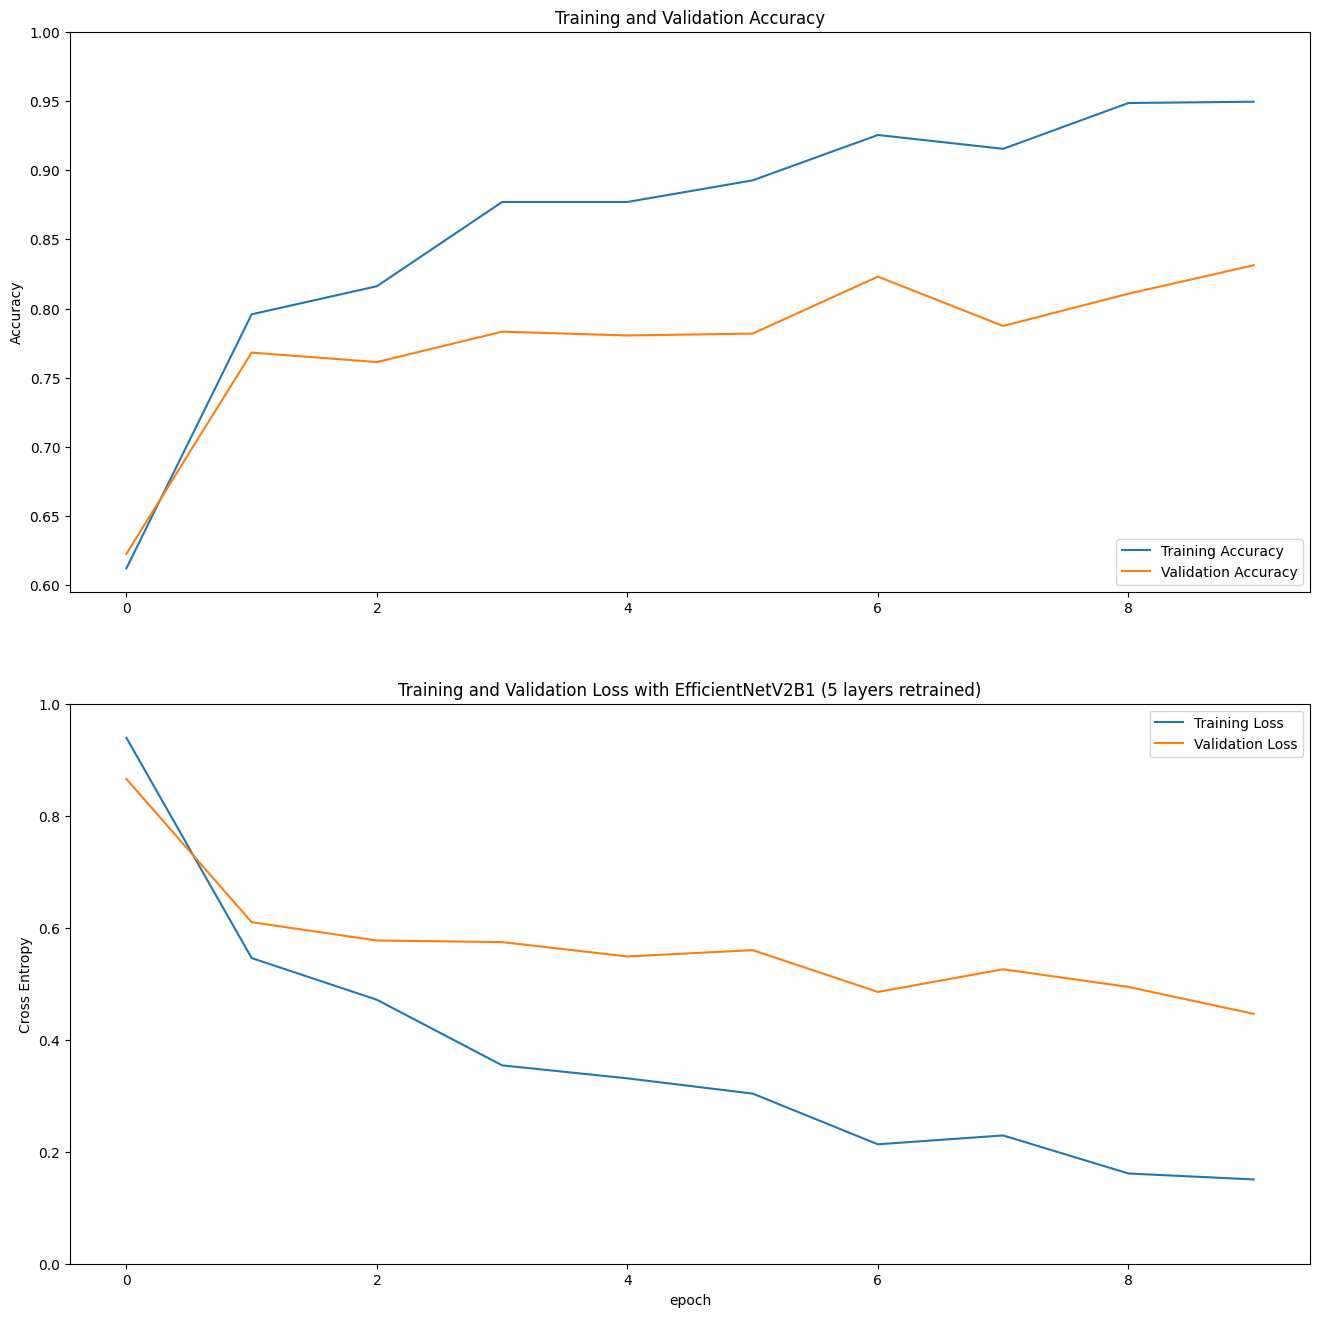

<Figure size 640x480 with 0 Axes>

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss with EfficientNetV2B1 (5 layers retrained)')
plt.xlabel('epoch')
plt.show()
plt.savefig('train_val_acc_los_EfficientNetV2B1-5l.png', format='png', dpi='figure')